<a href="https://colab.research.google.com/github/klopetx/PHM_python_lectures/blob/main/src/03_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

project_path = 'PHM_python_lectures'

if not os.path.isdir(project_path):

  from google.colab import userdata
  gitpass = userdata.get('gpass')
  mailpass = userdata.get('mailpass')
  mytoken = userdata.get('mytoken')


  !git config --global user.name "klopetx"
  !git config --global user.email "klopetx@gmail.com"
  !git config --global user.password gitpass


  token = mytoken
  username = 'klopetx'
  repo = 'PHM_python_lectures'


  !git clone https://{token}@github.com/{username}/{repo}

os.chdir(project_path)

!python src/00_Environment_Checks.py

indicator_file_path = "data/10. FEMTO Bearing/indicators.csv"

if not os.path.isdir(project_path):
  print('Indicator dataset not found, extracting indicators...')
  !python src/01_Indicator_extraction.py
  print('Indicators extracted succesfully!')


Cloning into 'PHM_python_lectures'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 212 (delta 9), reused 0 (delta 0), pack-reused 192
Receiving objects: 100% (212/212), 2.01 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (125/125), done.
The '10. FEMTO Bearing' directory does not exist inside 'data'
Runnning data download...
FEMTO downloaded
Indicator dataset not found, extracting indicators...
Indicators extracted succesfully!


# Feature selection

When the amount of indicators/features/kpi-s we are working with is big. It is sometimes difficult to guarantee that they are all relevant for our purpose that is why we employ feature selection techniques to remove features that do not clearly contribute to approximating our problem at hand.





## The dataset

We have now a dataset which has some indicators extracted from each raw signal and, in addition, the time to failure has been included.

Let's load it an have a look:

In [2]:
import pandas as pd

indicators = pd.read_csv( "data/10. FEMTO Bearing/indicators.csv", sep = '\t')

indicators.head()

,Origin,Bearing,OperatingCondition,TestNumber,TestIdx,Hour,Minute,Second,Mili/centisecond,Mean,...,BPFO_rms,BPFI_max,BPFI_rms,BSF_max,BSF_rms,Timestamp,Duration,Actual_RUL,RUL,Alive
0,Full_Test_Set,Bearing2_4,2,4,1,8,3,36,462540.0,0.006552,...,3.462482,2.702957,2.455653,15.180564,13.488451,2000-01-01 08:03:36,0.0,1390,1390.0,True
1,Full_Test_Set,Bearing2_4,2,4,2,8,3,46,462540.0,0.001299,...,5.925823,5.629765,4.592479,18.305801,13.007734,2000-01-01 08:03:46,10.0,1390,1380.0,True
2,Full_Test_Set,Bearing2_4,2,4,3,8,3,56,462540.0,0.003271,...,3.938765,6.103561,4.583218,9.434037,8.430699,2000-01-01 08:03:56,20.0,1390,1370.0,True
3,Full_Test_Set,Bearing2_4,2,4,4,8,4,6,462540.0,0.003263,...,2.652722,6.837217,6.077246,13.578691,10.908141,2000-01-01 08:04:06,30.0,1390,1360.0,True
4,Full_Test_Set,Bearing2_4,2,4,5,8,4,16,462540.0,0.004246,...,3.710252,8.133538,6.903766,12.933754,9.514291,2000-01-01 08:04:16,40.0,1390,1350.0,True


In [3]:
indicators.columns

Index(['Origin', 'Bearing', 'OperatingCondition', 'TestNumber', 'TestIdx',
       'Hour', 'Minute', 'Second', 'Mili/centisecond', 'Mean',
       'Standard Deviation', 'RMS', 'Peak', 'Peak-to-Peak', 'Skewness',
       'Kurtosis', 'Crest Factor', 'Form Factor', 'Impulse Factor',
       'Margin Factor', 'Total Energy', 'Max Power Frequency',
       'Spectral Centroid', 'Spectral Bandwidth', 'Spectral Flatness',
       'Spectral Roll-off', 'BPFO_max', 'BPFO_rms', 'BPFI_max', 'BPFI_rms',
       'BSF_max', 'BSF_rms', 'Timestamp', 'Duration', 'Actual_RUL', 'RUL',
       'Alive'],
      dtype='object')

Use the following chunk to visualize some of the variables, pay spetial attention to RUL (Remaining Useful Life).

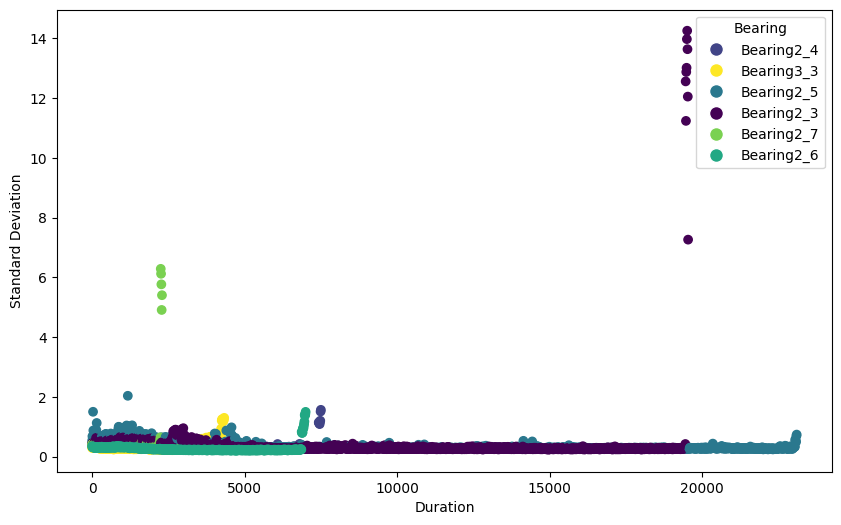

In [4]:
import matplotlib.pyplot as plt

target_variable = 'Standard Deviation' # select one from indicators.columns

def plot_indicator_by_bearing(target_variable):

    # Create a scatter plot
    indicators['Bearings_code'] = pd.Categorical(indicators['Bearing']).codes

    plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
    scatter = plt.scatter(indicators['Duration'], indicators[target_variable], c=indicators['Bearings_code'], cmap='viridis')
    legend_labels = pd.unique(indicators['Bearing'])
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=bearing,
                          markersize=10, markerfacecolor=scatter.cmap(scatter.norm(indicators[indicators['Bearing'] == bearing]['Bearings_code'].iloc[0]))) for bearing in legend_labels]
    plt.legend(handles=handles, title='Bearing')
    plt.xlabel('Duration')
    plt.ylabel(target_variable)

    plt.show()

    return
plot_indicator_by_bearing(target_variable)

The RUL has been added based on the documentation of the dataset. RUL reflects the time left until the machine is no longer operative. According to the people who carried out the experiment, a the  point at which the RUL is equal to 0 or a negative value the machine cannot be considered to be working properly.

We will call RUL the **target variable** that is, the variable we want to infer from the remaining variables.

Use plot_indicator_by_bearing to plot the RUL indicator and answer the following questions:

### Questions


1.   Do all tested bearings last the same?

2.   Is the whole life of a bearing equally important?




## Variables of interest

For modelling purposes, we would ideally have a variable (or more) that would behave similarly to the RUL that is, a variable (of set of variables) that correlate well with the RUL indicator.

The question is, how do we know that?

One way would be by visually assessing wether there is any indicator that has similar behaviour as the RUL.

<ipython-input-5-4bbd44e86b2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indicatordf['Bearings_code'] = pd.Categorical(indicatordf['Bearing']).codes


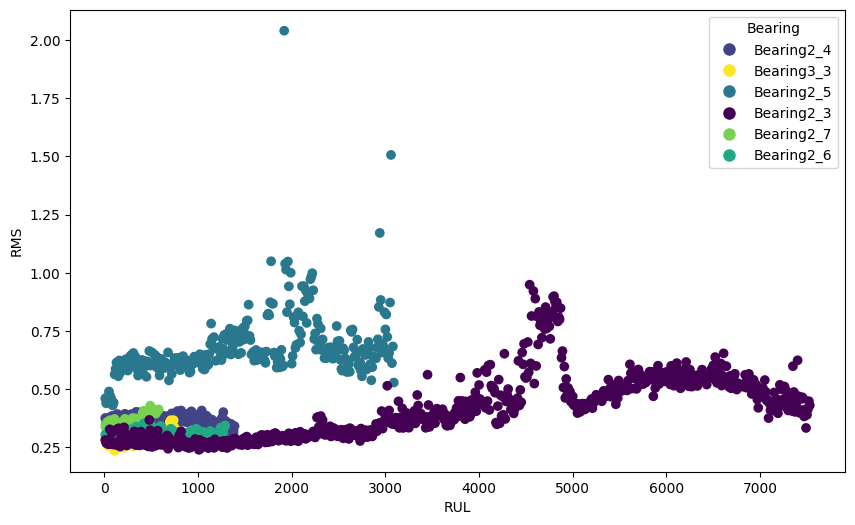

In [5]:
def plot_indicator_vs_indicator(indicatordf, indicator_1, indicator_2):

    # Create a scatter plot
    indicatordf['Bearings_code'] = pd.Categorical(indicatordf['Bearing']).codes

    plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
    scatter = plt.scatter(indicatordf[indicator_1], indicatordf[indicator_2], c=indicatordf['Bearings_code'], cmap='viridis')
    legend_labels = pd.unique(indicators['Bearing'])
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=bearing,
                          markersize=10, markerfacecolor=scatter.cmap(scatter.norm(indicatordf[indicatordf['Bearing'] == bearing]['Bearings_code'].iloc[0]))) for bearing in legend_labels]
    plt.legend(handles=handles, title='Bearing')
    plt.xlabel(indicator_1)
    plt.ylabel(indicator_2)

    plt.show()

    return

indicators_alive = indicators.loc[indicators['Alive'] == True]

plot_indicator_vs_indicator(indicators_alive,'RUL', 'RMS')

However, this is slow and does not scale well when he have many indicators.

How could we simplify that search?



## Correlation

In [6]:
indicators['Alive'].value_counts()

Alive
False    4912
True     1470
Name: count, dtype: int64

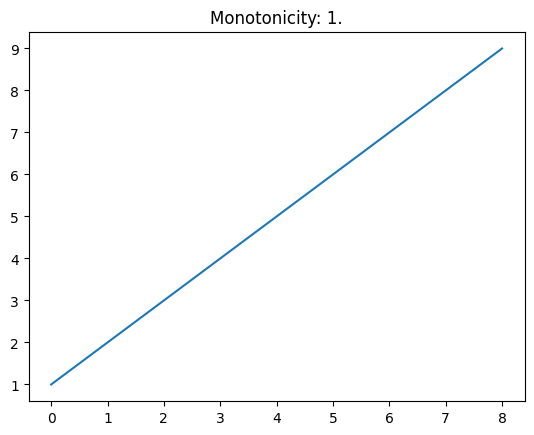

In [7]:
import numpy as np

input = np.array([1,2,3,4,5,6,7,8,9])

def compute_monotonicity(input):

  diff_input = np.diff(input)

  monotonicity = np.abs(np.sum(diff_input> 0)/(len(input) - 1) - np.sum(diff_input < 0)/(len(input) - 1))

  plt.plot(input)
  plt.title('Monotonicity: ' + np.array2string(monotonicity))


compute_monotonicity(input)

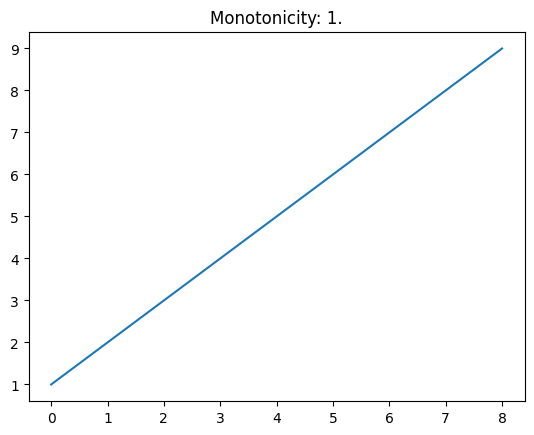

In [8]:
input = np.array([1,2,3,4,5,6,7,8,9])

compute_monotonicity(input)


In [9]:


inputdf = indicators.copy()




### Trendability

In [10]:
def find_closest_idx(arr, ref_arr):
    indices = []
    for value in ref_arr:
        index = (np.abs(arr - value)).argmin()
        indices.append(index)
    return np.array(indices)

input = np.arange(1,10)

find_closest_idx(input, np.array([3.4, 6]))


array([2, 5])

In [11]:
np.arange(0,560,1)

indicators.groupby('Bearing')['RUL'].agg(lambda x: np.max(x[x>0]))

len(np.arange(1,580,1))

579

In [62]:
homoidexRUL = np.arange(0,579,25)

def substract_homogeneous_RUL_values(bearing_grouped_df, RUL_idex):

    # breakpoint()

    indexes_to_substract = find_closest_idx(bearing_grouped_df['RUL'], RUL_idex)

    output = bearing_grouped_df.iloc[indexes_to_substract]

    return output

correlation_df = inputdf.groupby('Bearing').apply(lambda x: substract_homogeneous_RUL_values(x, homoidexRUL)).reset_index(level='Bearing', drop=True).copy()

In [64]:
def compute_lowest_correlation(data, column_name):
    """
    Given a DataFrame and a column name, compute the correlation
    between all groups identified by 'Bearing' for the specified column.

    Parameters:
    - data: DataFrame containing the groups and values
    - column_name: The name of the column to compute correlations on

    Returns:
    - A tuple containing the lowest correlation value and the pair of groups.
    """
    # Group the DataFrame by 'Bearing'
    grouped = data.groupby('Bearing')[column_name]

    # Get the unique groups
    groups = data['Bearing'].unique()

    # Initialize a variable to store the lowest correlation
    lowest_correlation = 1.0
    lowest_pair = None

    # Compute the correlation between all pairs of groups
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]

            # Get the values for each pair of groups
            values1 = grouped.get_group(group1).values
            values2 = grouped.get_group(group2).values

            # To correlate, both arrays need to be of the same length
            min_length = min(len(values1), len(values2))
            if min_length == 0:  # Skip if there are no elements to compare
                continue

            # Truncate the arrays to the same length
            values1 = values1[:min_length]
            values2 = values2[:min_length]

            # Compute the correlation
            correlation = np.abs(np.corrcoef(values1, values2)[0, 1])

            # Check if this is the lowest correlation so far
            if correlation < lowest_correlation:
                lowest_correlation = correlation
                lowest_pair = (group1, group2)

    return lowest_correlation, lowest_pair

compute_lowest_correlation(correlation_df, 'RMS')

(0.0013959401857803208, ('Bearing2_3', 'Bearing2_6'))

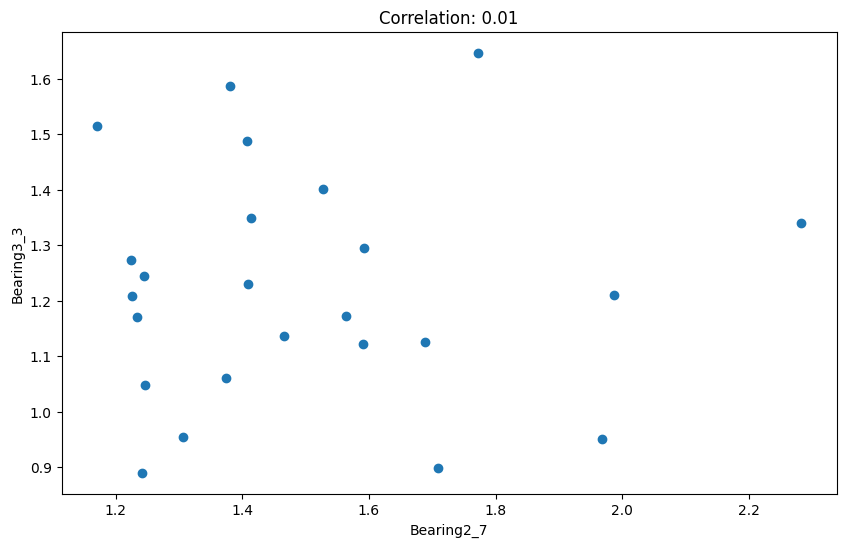

In [84]:
def plot_lowest_correlation(data, column_name):
    """
    Computes the lowest correlation between groups identified by 'Bearing' for the specified column,
    and plots the two bearings with the lowest correlation.

    Parameters:
    - data: DataFrame containing the groups and values.
    - column_name: The name of the column to compute correlations on.
    """
    # Compute the lowest correlation and the pair of bearings
    lowest_correlation, lowest_pair = compute_lowest_correlation(data, column_name)

    if lowest_pair is None:
        print("Insufficient data for correlation.")
        return

    # Extract the data for the two bearings with the lowest correlation
    bearing1_data = data[data['Bearing'] == lowest_pair[0]][column_name].values
    bearing2_data = data[data['Bearing'] == lowest_pair[1]][column_name].values

    # To plot, both arrays need to be of the same length
    min_length = min(len(bearing1_data), len(bearing2_data))
    bearing1_data = bearing1_data[:min_length]
    bearing2_data = bearing2_data[:min_length]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(bearing1_data, bearing2_data, marker='o', linestyle='')
    plt.xlabel(lowest_pair[0])
    plt.ylabel(lowest_pair[1])
    plt.title(f"Correlation: {lowest_correlation:.2f}")
    plt.show()

def compute_lowest_correlation(data, column_name):
    """
    Computes the lowest correlation between groups identified by 'Bearing' for the specified column.
    """
    grouped = data.groupby('Bearing')[column_name]
    groups = data['Bearing'].unique()
    lowest_correlation = 1.0
    lowest_pair = None

    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1, group2 = groups[i], groups[j]
            values1, values2 = grouped.get_group(group1).values, grouped.get_group(group2).values
            min_length = min(len(values1), len(values2))

            if min_length > 0:
                correlation = np.abs(np.corrcoef(values1[:min_length], values2[:min_length])[0, 1])
                if correlation < lowest_correlation:
                    lowest_correlation = correlation
                    lowest_pair = (group1, group2)

    return lowest_correlation, lowest_pair

plot_lowest_correlation(correlation_df, 'Peak')

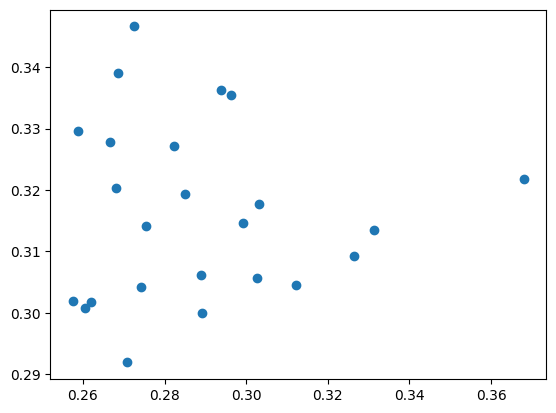

array([0.30570517, 0.29189842, 0.32718762, 0.30444777, 0.30180698,
       0.30920931, 0.31341057, 0.31462618, 0.30615042, 0.32023914,
       0.30413385, 0.32788429, 0.31933365, 0.30072445, 0.33548749,
       0.32966069, 0.31770676, 0.33631628, 0.33905254, 0.32182126,
       0.34663118, 0.30000956, 0.3019737 , 0.31418057])

In [51]:
correlation_vector_index = np.arange(1,59,1)

correlation_vector_index
indicators.groupby('Bearing')['RUL'].agg(lambda x: np.max(x[x>0]))
indicators.groupby('Bearing')['RUL'].count()

Bearing
Bearing2_3    1955
Bearing2_4     751
Bearing2_5    2311
Bearing2_6     701
Bearing2_7     230
Bearing3_3     434
Name: RUL, dtype: int64

In [48]:
correlation_vector_index = np.arange(0,230,1) # Taking indexes until shortest path

inputdf.groupby('Bearing').apply(lambda x: get_indices(x, correlation_vector_index)).reset_index(level='Bearing', drop=True)

,Origin,Bearing,OperatingCondition,TestNumber,TestIdx,Hour,Minute,Second,Mili/centisecond,Mean,...,BPFI_max,BPFI_rms,BSF_max,BSF_rms,Timestamp,Duration,Actual_RUL,RUL,Alive,Bearings_code
308,Full_Test_Set,Bearing2_3,2,3,1,8,39,57,571910.0,-0.003496,...,1.578888,1.467249,14.015225,12.668808,2000-01-01 08:39:57,0.0,7530,7530.0,True,0
312,Full_Test_Set,Bearing2_3,2,3,2,8,40,7,571910.0,0.001170,...,6.828376,6.206636,5.958273,5.137034,2000-01-01 08:40:07,10.0,7530,7520.0,True,0
316,Full_Test_Set,Bearing2_3,2,3,3,8,40,17,571910.0,0.004272,...,4.341753,3.199408,9.502175,6.818941,2000-01-01 08:40:17,20.0,7530,7510.0,True,0
321,Full_Test_Set,Bearing2_3,2,3,4,8,40,27,571910.0,0.001515,...,1.883259,1.668801,18.500167,14.576969,2000-01-01 08:40:27,30.0,7530,7500.0,True,0
326,Full_Test_Set,Bearing2_3,2,3,5,8,40,37,571910.0,0.005896,...,6.114721,5.125518,6.696898,5.037933,2000-01-01 08:40:37,40.0,7530,7490.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Full_Test_Set,Bearing3_3,3,3,196,9,0,3,212540.0,-0.054658,...,6.784926,5.544798,13.622216,10.608944,2000-01-01 09:00:03,1950.0,820,-1130.0,False,5
961,Full_Test_Set,Bearing3_3,3,3,197,9,0,13,212540.0,-0.019946,...,4.192537,3.095520,11.655679,11.344880,2000-01-01 09:00:13,1960.0,820,-1140.0,False,5
967,Full_Test_Set,Bearing3_3,3,3,198,9,0,23,212540.0,0.004904,...,14.452856,10.298424,6.791259,5.639892,2000-01-01 09:00:23,1970.0,820,-1150.0,False,5
973,Full_Test_Set,Bearing3_3,3,3,199,9,0,33,212540.0,-0.049807,...,4.972427,4.589999,11.397744,9.487744,2000-01-01 09:00:33,1980.0,820,-1160.0,False,5




### Prognosability

In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0004370222000078

# def compute_prognosability(inputdf):

target_var = 'RMS'

p_fail = inputdf.loc[inputdf['Alive'] == False][target_var].values

p_start = inputdf.loc[inputdf['Alive'] == True][target_var].values

prognosability_score = np.exp(-np.std(p_fail) / np.abs(np.mean(p_start) - np.mean(p_fail)))

prognosability_score
# prognosability = np.exp()



In [ ]:
target_var = 'Peak'

p_fail = inputdf.loc[inputdf['Alive'] == False][target_var].values

In [ ]:
print(len(p_fail))
print(len(p_start))
print(len(inputdf[target_var]))
